In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# Choose a pre-trained model (e.g., VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
# Add custom top layers for CIFAR10
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512),
    layers.LeakyReLU(negative_slope=0.1),  # Leaky ReLU activation
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(10, activation='softmax')  # Output for CIFAR10
])

model.summary()

# Freeze base model layers for initial evaluation
for layer in base_model.layers:
    layer.trainable = False

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,452,554 (78.02 MB)

 Trainable params: 20,452,554 (78.02 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile and evaluate without fine-tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Evaluating with pre-trained weights:")
model.evaluate(x_test, y_test)

Evaluating with pre-trained weights:
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0404 - loss: 2.4617


[2.462237596511841, 0.04170000180602074]

In [23]:
# Fine-tune the model
for layer in base_model.layers:
    layer.trainable = True  # Unfreeze for fine-tuning

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 65ms/step - accuracy: 0.2962 - loss: 1.9593 - val_accuracy: 0.6823 - val_loss: 0.9445
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 127s 61ms/step - accuracy: 0.6816 - loss: 0.9860 - val_accuracy: 0.7513 - val_loss: 0.7393
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 61ms/step - accuracy: 0.7536 - loss: 0.7695 - val_accuracy: 0.7793 - val_loss: 0.6761
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 60ms/step - accuracy: 0.7942 - loss: 0.6436 - val_accuracy: 0.8035 - val_loss: 0.5854
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 94s 60ms/step - accuracy: 0.8248 - loss: 0.5546 - val_accuracy: 0.8047 - val_loss: 0.6005
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.8442 - loss: 0.4800 - val_accuracy: 0.8209 - val_loss: 0.5436
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.8678 - loss: 0.4133 - val_accuracy: 0.8227 - val_loss: 0.5486
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0

In [11]:
# Evaluate the fine-tuned model
print("Evaluating after fine-tuning:")
model.evaluate(x_test, y_test)

Evaluating after fine-tuning:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8311 - loss: 0.5933


[0.5924311280250549, 0.8310999870300293]

In [12]:
import matplotlib.pyplot as plt

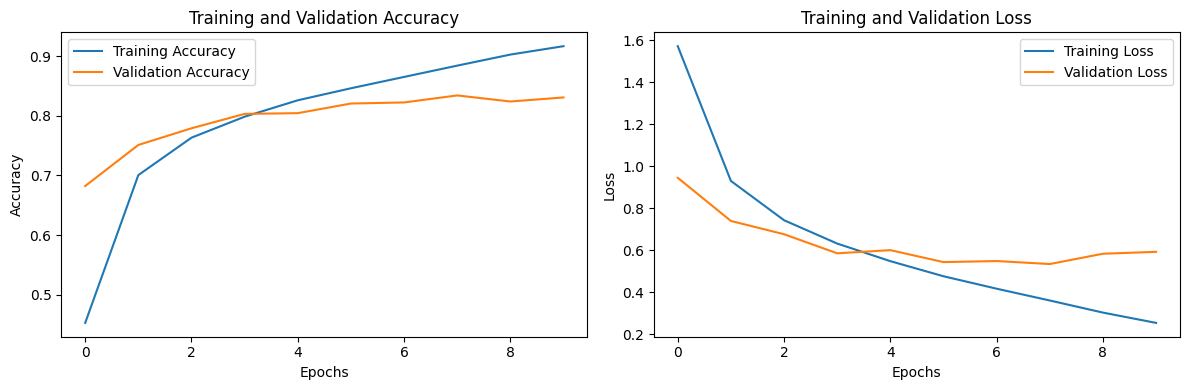

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()